# Задача классификации рукописных арабских цифр
## _С помощью кластеризации и автоэнкодера для снижения размерности данных_

In [1]:
import numpy
import time
import matplotlib.pyplot as plt

import sklearn
import sklearn.datasets # load_digits()
import sklearn.cluster # KMeans
import sklearn.metrics

import math

%matplotlib inline

## 1. Загрузка данных

In [2]:
digits = sklearn.datasets.load_digits()
data = digits['data']
labels = digits['target']

In [3]:
data

array([[ 0.,  0.,  5., ...,  0.,  0.,  0.],
       [ 0.,  0.,  0., ..., 10.,  0.,  0.],
       [ 0.,  0.,  0., ..., 16.,  9.,  0.],
       ...,
       [ 0.,  0.,  1., ...,  6.,  0.,  0.],
       [ 0.,  0.,  2., ..., 12.,  0.,  0.],
       [ 0.,  0., 10., ..., 12.,  1.,  0.]])

In [4]:
len(data), len(data[0])

(1797, 64)

Посмотрим минимальные и максимальные значение пикселей:

In [5]:
min([min(v) for v in data]), max([max(v) for v in data])

(0.0, 16.0)

А также метки и их количество:

In [6]:
labels, sorted(set(labels))

(array([0, 1, 2, ..., 8, 9, 8]), [0, 1, 2, 3, 4, 5, 6, 7, 8, 9])

In [7]:
len(labels)

1797

__Итак, в размеченном наборе данных всего 1797 цифр, каждая представлена одномерным массивом из 64 элементов (8x8 пикселей)__.

Так они выглядят (первые 50 изображений).

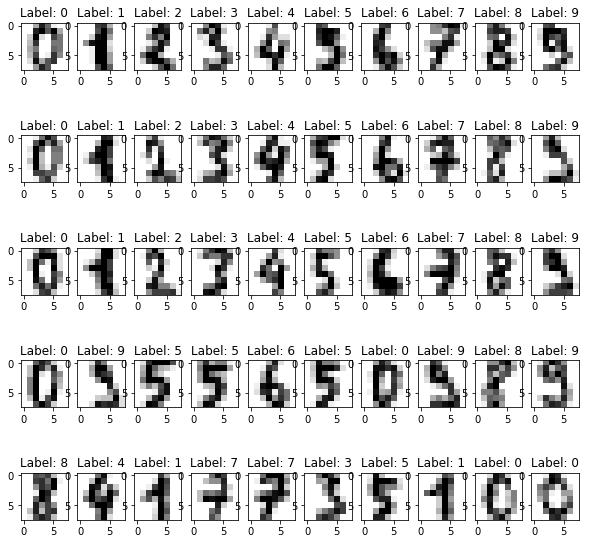

In [8]:
plt.figure(figsize=(10,10))
for i in range(50):
    plt.subplot(5, 10, i + 1)
    plt.imshow(digits.images[i], cmap=plt.cm.gray_r, interpolation='nearest')
    plt.title(f'Label: {labels[i]}')

## 2. Используемые методы (немного матана)

### Алгоритм K-Means:
K-Means это один из самых используемых алгоритмов кластеризации.
По данным и числу кластеров $k$, он итеративно вычисляет распределение объектов по k кластерам {$S_1, \dots, S_k$} и центры кластеров, минимизируя суммарное расстояние от центров кластеров до объектов, которые к ним относятся:

$$\sum\limits_{i=1}^{k} \sum\limits_{j:x_j\in S_i}^n\|x_j-m_i\|^2$$
Где $k$ число кластеров, $n$ число объектов, $S_i$ это $i$-ый кластер с центром в  $m_i$, $x_j$ это $j$-ый объект.

### Автоэнкодеры:

Автоэнкодеры — это нейронные сети прямого распространения, которые восстанавливают входной сигнал на выходе. Внутри у них имеется скрытый слой, который представляет собой код, описывающий модель. Автоэнкодеры конструируются таким образом, чтобы не иметь возможность точно скопировать вход на выходе.

Автоэнкодеры состоят из двух частей: энкодера $g$ и декодера $f$. Энкодер переводит входной сигнал в его представление (код): $h=g(x)$, а декодер восстанавливает сигнал по его коду: $x=f(h)$.

Автоэнкодер, изменяя $f$ и $g$, стремится выучить тождественную функцию $x=f(g(x))$, минимизируя какой-то функционал ошибки: $L(x, f(g(x))$.

In [9]:
%%html
<img src="http://localhost:8888/files/Projects/ml/examples/autoencoder.png"/>

## 3. Уменьшим размерность с помощью автоэнкодера

В этом случае будем использовать также нейронную сеть прямого распространения, только с большим количеством слоёв.

In [10]:
from keras.layers import Input, Dense
from keras.models import Model

c:\users\stas\envs\data_science\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [11]:
# input placeholder
input_image = Input(shape=(64,))
# encoded input from 64 to 32
encoded = Dense(32, activation='relu')(input_image)
# encoded previous layer from 32 to 16
encoded = Dense(16, activation='relu')(encoded)
# encoded previous layer from 16 to 4
encoded = Dense(4, activation='relu')(encoded)

# reconstruction of the encoded back from 4 to 16
decoded = Dense(16, activation='relu')(encoded)
# reconstruction of the previous layer back from 16 to 32
decoded = Dense(32, activation='relu')(decoded)
# reconstruction of the previous layer back from 32 to 64
decoded = Dense(64, activation='sigmoid')(decoded)

# autoencoder model 64 to 64 with losses
autoencoder = Model(input_image, decoded, name='autoencoder')

encoder = Model(input_image, encoded, name='encoder')

autoencoder.compile(optimizer='adadelta', loss='binary_crossentropy')

In [12]:
autoencoder.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 64)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 32)                2080      
_________________________________________________________________
dense_2 (Dense)              (None, 16)                528       
_________________________________________________________________
dense_3 (Dense)              (None, 4)                 68        
_________________________________________________________________
dense_4 (Dense)              (None, 16)                80        
_________________________________________________________________
dense_5 (Dense)              (None, 32)                544       
_________________________________________________________________
dense_6 (Dense)              (None, 64)                2112      
Total para

In [13]:
norm_data = data.astype('float32') / 16.0
len(norm_data), len(norm_data[0])

(1797, 64)

In [14]:
%%time
autoencoder.fit(norm_data, norm_data, epochs=500, batch_size=64, shuffle=True)

Epoch 1/500
1797/1797 [==============================] - 2s 856us/step - loss: 0.6872
Epoch 2/500
1797/1797 [==============================] - 0s 215us/step - loss: 0.6325
Epoch 3/500
1797/1797 [==============================] - 0s 155us/step - loss: 0.4434
Epoch 4/500
1797/1797 [==============================] - 0s 160us/step - loss: 0.4247
Epoch 5/500
1797/1797 [==============================] - 0s 142us/step - loss: 0.4225
Epoch 6/500
1797/1797 [==============================] - 0s 176us/step - loss: 0.4206
Epoch 7/500
1797/1797 [==============================] - 0s 69us/step - loss: 0.4172
Epoch 8/500
1797/1797 [==============================] - 0s 49us/step - loss: 0.4109
Epoch 9/500
1797/1797 [==============================] - 0s 52us/step - loss: 0.4021
Epoch 10/500
1797/1797 [==============================] - 0s 48us/step - loss: 0.3932
Epoch 11/500
1797/1797 [==============================] - 0s 72us/step - loss: 0.3871
Epoch 12/500
1797/1797 [==============================] -

1797/1797 [==============================] - 0s 44us/step - loss: 0.3410
Epoch 97/500
1797/1797 [==============================] - 0s 47us/step - loss: 0.3405
Epoch 98/500
1797/1797 [==============================] - 0s 48us/step - loss: 0.3401
Epoch 99/500
1797/1797 [==============================] - 0s 44us/step - loss: 0.3397
Epoch 100/500
1797/1797 [==============================] - 0s 38us/step - loss: 0.3392
Epoch 101/500
1797/1797 [==============================] - 0s 39us/step - loss: 0.3388
Epoch 102/500
1797/1797 [==============================] - 0s 38us/step - loss: 0.3384
Epoch 103/500
1797/1797 [==============================] - 0s 41us/step - loss: 0.3383
Epoch 104/500
1797/1797 [==============================] - 0s 39us/step - loss: 0.3379
Epoch 105/500
1797/1797 [==============================] - 0s 42us/step - loss: 0.3374
Epoch 106/500
1797/1797 [==============================] - 0s 39us/step - loss: 0.3372
Epoch 107/500
1797/1797 [==============================] - 0

1797/1797 [==============================] - 0s 51us/step - loss: 0.3249
Epoch 191/500
1797/1797 [==============================] - 0s 52us/step - loss: 0.3249
Epoch 192/500
1797/1797 [==============================] - 0s 52us/step - loss: 0.3250
Epoch 193/500
1797/1797 [==============================] - 0s 47us/step - loss: 0.3246
Epoch 194/500
1797/1797 [==============================] - 0s 49us/step - loss: 0.3249
Epoch 195/500
1797/1797 [==============================] - 0s 51us/step - loss: 0.3249
Epoch 196/500
1797/1797 [==============================] - 0s 49us/step - loss: 0.3247
Epoch 197/500
1797/1797 [==============================] - 0s 58us/step - loss: 0.3245
Epoch 198/500
1797/1797 [==============================] - 0s 49us/step - loss: 0.3246
Epoch 199/500
1797/1797 [==============================] - 0s 58us/step - loss: 0.3245
Epoch 200/500
1797/1797 [==============================] - 0s 67us/step - loss: 0.3247
Epoch 201/500
1797/1797 [==============================] 

1797/1797 [==============================] - 0s 55us/step - loss: 0.3168
Epoch 285/500
1797/1797 [==============================] - 0s 42us/step - loss: 0.3169
Epoch 286/500
1797/1797 [==============================] - 0s 52us/step - loss: 0.3167
Epoch 287/500
1797/1797 [==============================] - 0s 55us/step - loss: 0.3172
Epoch 288/500
1797/1797 [==============================] - 0s 62us/step - loss: 0.3167
Epoch 289/500
1797/1797 [==============================] - 0s 56us/step - loss: 0.3163
Epoch 290/500
1797/1797 [==============================] - 0s 54us/step - loss: 0.3165
Epoch 291/500
1797/1797 [==============================] - 0s 60us/step - loss: 0.3167
Epoch 292/500
1797/1797 [==============================] - 0s 53us/step - loss: 0.3168
Epoch 293/500
1797/1797 [==============================] - 0s 52us/step - loss: 0.3165
Epoch 294/500
1797/1797 [==============================] - 0s 46us/step - loss: 0.3161
Epoch 295/500
1797/1797 [==============================] 

1797/1797 [==============================] - 0s 57us/step - loss: 0.3116
Epoch 379/500
1797/1797 [==============================] - 0s 54us/step - loss: 0.3119
Epoch 380/500
1797/1797 [==============================] - 0s 46us/step - loss: 0.3115
Epoch 381/500
1797/1797 [==============================] - 0s 47us/step - loss: 0.3114
Epoch 382/500
1797/1797 [==============================] - 0s 53us/step - loss: 0.3113
Epoch 383/500
1797/1797 [==============================] - 0s 48us/step - loss: 0.3117
Epoch 384/500
1797/1797 [==============================] - 0s 54us/step - loss: 0.3112
Epoch 385/500
1797/1797 [==============================] - 0s 53us/step - loss: 0.3114
Epoch 386/500
1797/1797 [==============================] - 0s 49us/step - loss: 0.3116
Epoch 387/500
1797/1797 [==============================] - 0s 54us/step - loss: 0.3111
Epoch 388/500
1797/1797 [==============================] - 0s 55us/step - loss: 0.3112
Epoch 389/500
1797/1797 [==============================] 

1797/1797 [==============================] - 0s 50us/step - loss: 0.3082
Epoch 473/500
1797/1797 [==============================] - 0s 52us/step - loss: 0.3081
Epoch 474/500
1797/1797 [==============================] - 0s 39us/step - loss: 0.3078
Epoch 475/500
1797/1797 [==============================] - 0s 43us/step - loss: 0.3079
Epoch 476/500
1797/1797 [==============================] - 0s 47us/step - loss: 0.3080
Epoch 477/500
1797/1797 [==============================] - 0s 60us/step - loss: 0.3081
Epoch 478/500
1797/1797 [==============================] - 0s 52us/step - loss: 0.3079
Epoch 479/500
1797/1797 [==============================] - 0s 51us/step - loss: 0.3073
Epoch 480/500
1797/1797 [==============================] - 0s 42us/step - loss: 0.3075
Epoch 481/500
1797/1797 [==============================] - 0s 43us/step - loss: 0.3076
Epoch 482/500
1797/1797 [==============================] - 0s 48us/step - loss: 0.3078
Epoch 483/500
1797/1797 [==============================] 

In [15]:
data_reduced = encoder.predict(norm_data)
len(data_reduced), len(data_reduced[0])

(1797, 4)

__Таким образом, от элементов размера 64 мы перешли к элементам меньшей размерности (в данном случае, размерность равна 4)__.

## 4. Кластеризация с помощью алгоритма K-means 

In [16]:
%%time
kmeans = sklearn.cluster.KMeans(n_clusters=10, max_iter=1000, tol=0, n_jobs=-1)
kmeans.fit(data_reduced)

Wall time: 6.45 s


Посмотрим теперь, как разложились входные данные по кластерам. Если построить гистограмму (можно мысленно), то легко оценить качество получившегося разбиения по входным меткам.

In [17]:
cluster_mapping = {i: [0 for j in range(10)] for i in range(10)}
for l, k in zip(labels, kmeans.labels_):
    cluster_mapping[l][k] += 1
cluster_mapping  

{0: [0, 0, 0, 0, 0, 163, 10, 4, 0, 1],
 1: [0, 2, 1, 26, 2, 0, 0, 53, 95, 3],
 2: [17, 3, 0, 140, 0, 0, 0, 11, 5, 1],
 3: [141, 3, 0, 5, 2, 0, 0, 31, 0, 1],
 4: [0, 1, 146, 0, 3, 1, 6, 0, 0, 24],
 5: [17, 79, 0, 0, 0, 4, 0, 80, 0, 2],
 6: [0, 0, 0, 0, 0, 9, 169, 2, 1, 0],
 7: [0, 1, 2, 0, 102, 0, 0, 0, 1, 73],
 8: [59, 18, 0, 0, 2, 0, 0, 54, 40, 1],
 9: [104, 3, 0, 0, 4, 7, 0, 38, 0, 24]}

Итак, можно предположить по принципу простого большинства такое прямое соответствие:

In [18]:
for k, v in cluster_mapping.items():
    print(f'{k} <= {v.index(max(v))}')

0 <= 5
1 <= 8
2 <= 3
3 <= 0
4 <= 2
5 <= 7
6 <= 6
7 <= 4
8 <= 0
9 <= 0


__Оценим качество кластеризации *как полагается* по науке__

- Homogenity: http://scikit-learn.org/stable/modules/generated/sklearn.metrics.homogeneity_score.html
- Completeness: http://scikit-learn.org/stable/modules/generated/sklearn.metrics.completeness_score.html
- V-Measure: http://scikit-learn.org/stable/modules/generated/sklearn.metrics.v_measure_score.html

In [123]:
print("Homogeneity: %0.3f" % sklearn.metrics.homogeneity_score(labels, kmeans.labels_))
print("Completeness: %0.3f" % sklearn.metrics.completeness_score(labels, kmeans.labels_))
print("V-measure: %0.3f" % sklearn.metrics.v_measure_score(labels, kmeans.labels_))

Homogeneity: 0.575
Completeness: 0.593
V-measure: 0.584


Прямо скажем, не очень. На самом деле, вот это самое "не очень" хорошо видно уже из таблички **cluster_mapping**, которая была подсчитана выше.

## 5. Тестовая картинка с цифрой 0, которую мы попытаемся распознать

In [124]:
img = plt.imread('0_small.png')

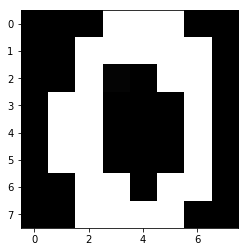

In [125]:
plt.imshow(img, cmap='gray')

In [126]:
len(img), len(img[0]), len(img[0][0])

(8, 8, 3)

Видно, что загруженная PNG картинка устроена по-другому, не так как тестовый набор __digits__ в __sklearn__: это двумерный массив 8x8, каждый элемент которого это RGB-тройка, причем компоненты RGB - это числа с плавающей точкой от 0 до 1. А `sklearn.datasets.load_digits()` возвращает пиксели как число от 0 до 16 (http://scikit-learn.org/stable/modules/generated/sklearn.datasets.load_digits.html).
Таким образом, нам надо свернуть (R,G,B) в одно число с максимальным значением 16. Сделаем это, например, так:

In [127]:
transformed_img = list()
for line in img:
    for pixel in line:
        com_r = pixel[0]
        com_g = pixel[1]
        com_b = pixel[2]
        transformed_img.append(int(math.sqrt(com_r**2 + com_g**2 + com_b**2) * 16 / math.sqrt(3)))

Редуцируем размерность внутренним слоем автоэнкодера:

In [128]:
d = encoder.predict(numpy.array([transformed_img]))
d

array([[ 0.      , 33.389263,  0.      ,  0.      ]], dtype=float32)

Предсказываем наиболее подходящий номер кластера:

In [129]:
r = kmeans.predict(d)
r

array([1])

Нет, не угадали.
Теперь проверим цифры из набора.

In [130]:
d = encoder.predict(numpy.array([norm_data[0]]))
d

array([[1.7031548, 5.4915185, 0.       , 0.       ]], dtype=float32)

In [131]:
kmeans.predict(d)

array([0])

Правильное предположение. И ещё одна попытка (случайный выбор):

In [132]:
d = encoder.predict(numpy.array([norm_data[16]]))
d

array([[ 0.      , 12.093934,  0.      ,  0.      ]], dtype=float32)

In [133]:
kmeans.predict(d)

array([5])

А вот мимо. Возьмём ещё цифру:

In [134]:
d = encoder.predict(numpy.array([norm_data[12]]))
d

array([[ 2.6378055, 14.51515  ,  0.       ,  0.       ]], dtype=float32)

In [135]:
kmeans.predict(d)

array([1])

Вывод закономерен: количество слоёв нейронной сети прямого распространения, вероятно, слабо не помогает для такого рода зача (работа с изображениями). Возможно, после определённого количества экспериментов мы смогли бы подобрать нужные параметры алгоритма, но это не то, что нам нужно. А нужно менять систему.